# 04. PyTorch Custom Datasets

Using PyTorch on custom datasets. The example we'll be using is of images of pizza, steak and sushi.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data 

We'll be using a subset of the [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.

Food101 is a popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods.

We'll start with 3: pizza, steak and sushi.

And instead of starting with 1000 images per class, we'll start with 10%: 100 images (start small, increase when necessary).

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} already exists, skipping download")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak sushi data
    with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak and sushi data...")
        f.write(request.content)
    
    # Unzip data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping the pizza, steak and sushi data...")
        zip_ref.extractall(image_path)
        print("Unzipped the data")

data\pizza_steak_sushi already exists, skipping download


## 2. Become one with the data (Data Preparation)

For a computer vision classification model, e.g. if we had to seperate between a dog and a cat, our dataset would contain 2 folders: 1 named dog and another named cat, each containing images only of the corresponding animal.

Our model follows the same structure.

To inspect what's inside our data directory, we can write a small helper function which uses `os.walk()`

In [4]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        Number of subdirectories in dir_path
        Number of images (files) in each subdirectory
        Name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")
    

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [6]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize and Image

1. Get all of the image paths using `pathlib.Path.glob()` to find all the files ending in `.jpg`.
2. Pick a random image path using Python's `random.choice`
3. Get image class name using `pathlib.Path.parent.stem`
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()`.
5. Show the image and print some metadata

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths (* means any combination)
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (image class is the name of the directory)
image_class = random_image_path.parent.name

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


We can display the image directly using PIL, if we want to display an image using `matplotlib.pyplot.imshow()`, we have to convert it into a Numpy array first.

(-0.5, 511.5, 407.5, -0.5)

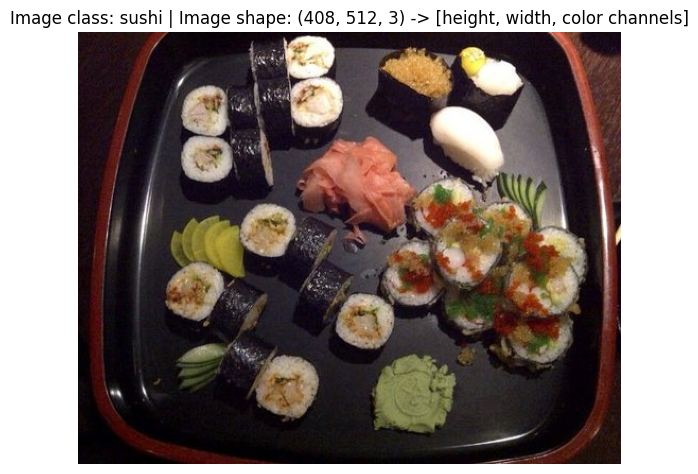

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(7, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False)

## 3. Transforming Data

Before loading our image data into PyTorch, we need to:
1. Turn images into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `Dataloader` for short.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for *data augmentation* purposes.

**Data augmentation**: The practice of altering data to make it harder for a model to learn.

Let's write a series of transformation steps:
1. Resize image using `transforms.Resize()` from about 512x512 to 64x64.
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (can be considered data augmentation as we artificially change our data).
3. Turn our images from PIL Image to PyTorch tensor using `transforms.ToTensor()`.

We can combine all of these steps using `torchvision.transforms.Compose()`

In [10]:
# Write transforms for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),         # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor()           # Also converts all pixel values from 0-255 to 0-1
])

Now that we have a composition of transforms, let's write a function to try them out on various images.

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """ Plots a series of random images from image_paths:
    
    Will open n image paths from image_paths, transform them with transform and plot them side by side.
    
    Args:
        image_paths (list): List of target image paths
        transform (PyTorch Transforms): Transforms to apply to images
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis('off')
            
            # Transform and plot image
            # Note: permute() will change shape of image to support matplotlib
            # PyTorch default: [C, H, W] -> Matplotlib default: [H, W, C]
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis('off')
            
            fig.suptitle(f"Class: {image_path.parent.name}", fontsize=16)

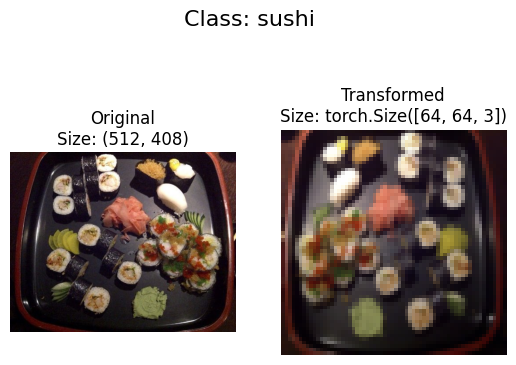

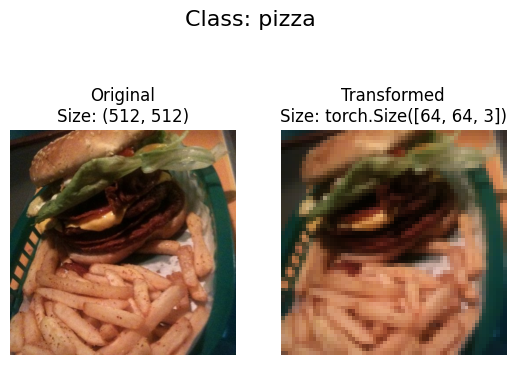

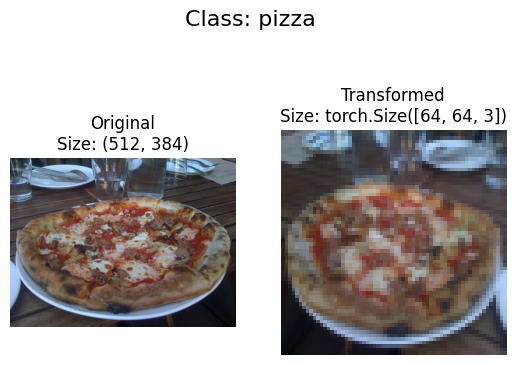

In [12]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

Now we can convert our images using `torchvision.transforms`.

Larger the shape of the image, the more info it can recover.

E.g. an image with shape `[256, 256, 3]` will have 16x more pixels than an image of shape `[64, 64, 3]` as `(256 * 256 * 3) / (64 * 64 * 3) = 16`.

More pixels require more computation, so it's a tradeoff you have to manage.

## 4. Option 1: Loading Image Data Using `ImageFolder`

Since our data is in the standard image classification format, we can use `torchvision.datasets.ImageFolder`.

In [13]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,           # target folder of images
                                  transform=data_transform, # how to transform images
                                  target_transform=None)    # Transforms to perform on label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

print(f"Train data:\n{train_data}\nTest Data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64])
Permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

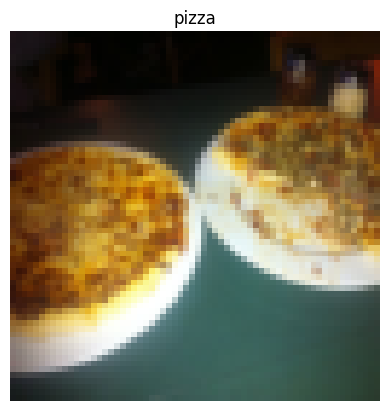

In [18]:
# Plot an image using matplotlib

# Rearrange the order of dimensions (C, H, W) -> (H, W, C)
img_permute = img.permute(1, 2, 0)

# Print out the shapes
print(f"Original shape: {img.shape}\nPermuted shape: {img_permute.shape}")
plt.axis('off')
plt.imshow(img_permute)
plt.title(class_names[label])

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

### 4.1 Turn loaded images into `DataLoader`'s

We have our images as a PyTorch `Dataset` but now let's turn them into a `DataLoader`.

Turning a dataset into a DataLoader makes it iterable so a model can go through and learn the relationships between samples and targets.

To keep things simple, we will keep `batch_size` = 1 and `num_workers` = 1

`num_workers` defines how many subprocesses will be created to load your data. The higher the value, the more compute PyTorch will use to load our data.

A good idea is to set it to the number of CPUs on your machine, which you can find out using `os.cpu_count()`. This ensures that the DataLoader uses as many cores as possible.

In [19]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,         # How many samples per batch
                              num_workers=1,        # Number of processes to use
                              shuffle=True)         # Shuffle the data

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)         # No need to shuffle the test data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x29bfff27df0>,
 <torch.utils.data.dataloader.DataLoader at 0x29b811b8490>)

Now our data is iterable.

In [20]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

We can also create our own custom way to load our Datasets if a pre-defined creator (like `torchvision.datasets.ImageFolder()`) doesn't exist.

Let's replicate `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all Datasets in PyTorch).

In [21]:
import os                               # For dealing with directories
import pathlib                          # For dealing with file paths
import torch

from PIL import Image                   # Loading images
from torch.utils.data import Dataset    # To subclass it and create our custom Dataset
from torchvision import transforms      # To turn our images into tensors
from typing import Tuple, Dict, List    # For type hints

### 5.1 Creating a helper function to get class names

To write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path, we need to:
1. Get class names using `os.scandir()` to traverse a target directory.
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels.

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / 'train'))])
print(f"Class names found: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
# Converting it into a function

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
# Testing our find_classes function
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Breaking it down:
1. Subclassing `torch.utils.data.Dataset`
2. Initialize our subclass with a `targ_dir` parameter and `transform` parameter
3. Create several attributes for `paths`, `transform`, `classes` and `classes_to_idx`.
4. Create a function to load images from file and return them, this could be using `PIL` or `torchvision.io` (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so that we can also call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the Dataset.

In [25]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize with a targ_dir and transform parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))       # NOTE: need to update if images are png, jpeg, etc.
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__ method (optional)
    def __len__(self) -> int:
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns 1 sample of data and label (X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name      # Expects path in data/train/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if required
        if self.transform:
            return self.transform(img), class_idx       # Returns data, label
        else:
            return img, class_idx

In [26]:
# Creating transforms to prepare our images
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x29b815efdf0>,
 <__main__.ImageFolderCustom at 0x29b815efd60>)

In [28]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


It all tallies!

### 5.3 Create a function to display random images

1. Take in the inputs: Dataset, the name of our target classes, the number of images to display (`n`) and a random seed.
2. To prevent the display from getting out of hand, cap `n` at 10 images.
3. Set the random seed
4. Get a list of random sample indexes using `random.sample()` to plot.
5. Setup a plot.
6. Loop through random sample indexes found in step 4 and plot them with matplotlib.
7. Ensure that the sample images are of shape `HWC` (height, width, color channels).

In [29]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

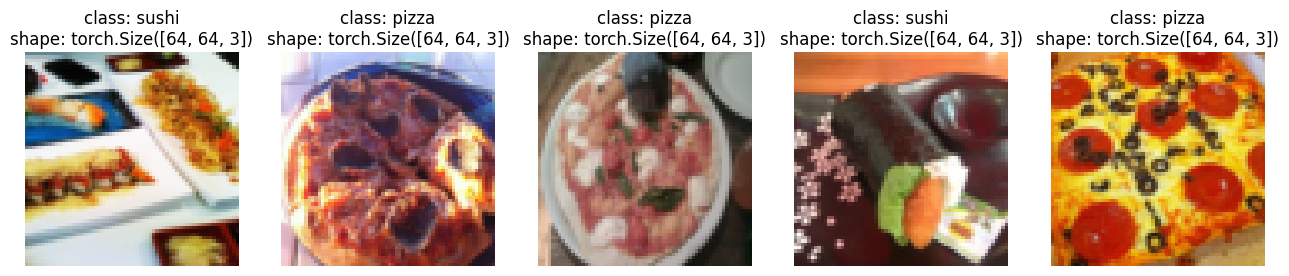

In [30]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into DataLoaders

In [31]:
# Turn train and test custom Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,         # Use custom created train Dataset
                                     batch_size=1,                      # How many samples per batch
                                     num_workers=0,                     # No additional subprocesses, will use main process
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x29b811a14e0>,
 <torch.utils.data.dataloader.DataLoader at 0x29b811a2110>)

In [32]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set. Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization.

Research shows that random transforms like `transforms.RandAugment()` and `transforms.TrivialAugmentWide()` generally performs better than hand-picked transforms.

**Trivial Augment:** You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range.

The main parameter in `TrivialAugmentWide()` is `num_magnitude_bins`. It defines how many different levels or *bins* of intensity there are for each data augmentation operation. `num_magnitude_bins=10` divides the range of possible strengths for each augmentation into 31 steps.

In [33]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# No need to perform augmentation on the test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

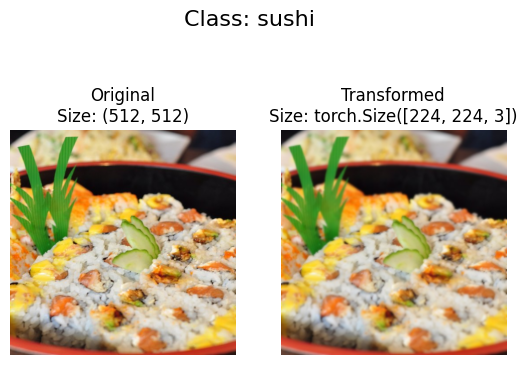

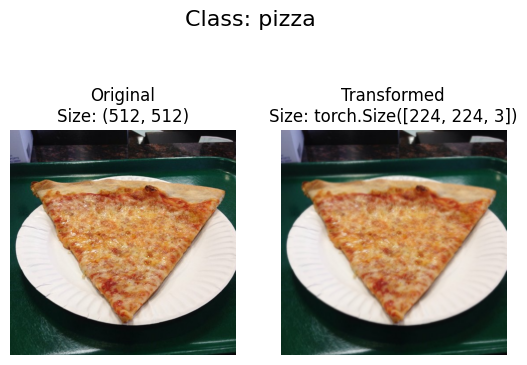

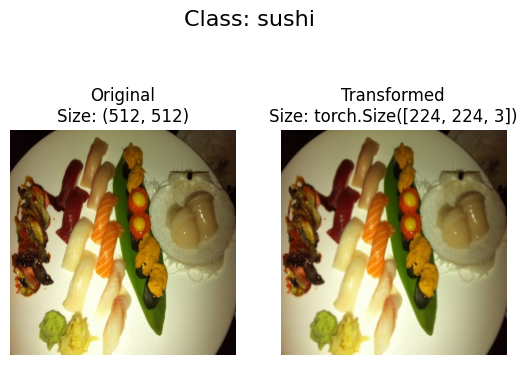

In [34]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without Data Augmentation

### 7.1 Creating transforms and loading data for Model 0

In [35]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Now:
1. Load the train and test data folders into a `Dataset`.
2. Then into a `DataLoader`.

In [36]:
# Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Set up batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoaders with batch size: {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoaders
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

Creating DataLoaders with batch size: 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x29b81076d40>,
 <torch.utils.data.dataloader.DataLoader at 0x29b81253c10>)

### 7.2 Create TinyVGG model class

In [37]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [38]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,            # number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)
                  ).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the forward() method in our model above, instead of calling a layer block and reassigning x every time, we call each block in succession (see the final line of the forward() method in the model above for an example).

This saves the time spent reassigning x (memory heavy) and focuses on only computing on x.

### 7.3 Try a forward pass on a single image

To do a forward pass:
1. Get a batch of images and labels from the `DataLoader`
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of 1 (so it's shape fits the model).
3. Perform inference on a single image
4. Print out what's happening and convert the raw logits to prediction probabilities with `torch.softmax()` and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [39]:
# 1. Get the batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze it
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}, Single label: {label_single}")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening & convert logits -> pred probs -> pred label
print(f"Output logits:\n{pred}")
print(f"Output prediction probabilities: {torch.softmax(pred, dim=1)}")
print(f"Output prediction label: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}")
print(f"Actual label: {label_single}")

Single image shape: torch.Size([1, 3, 64, 64]), Single label: 2
Output logits:
tensor([[0.0578, 0.0634, 0.0351]])
Output prediction probabilities: tensor([[0.3352, 0.3371, 0.3277]])
Output prediction label: tensor([1])
Actual label: 2


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model

In [40]:
!pip install torchinfo -qqq

In [41]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loop functions

We're going to make 3 functions:
1. `train_step()`: takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. `test_step()`: takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. `train()`: Performs 1 and 2 together for a given number of epochs and returns a result dictionary.

In [42]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [43]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`.

It will:
1. Take in a model, a train and test DataLoader, a loss function and an optimizer.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values.
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the results dictionary with the updated metrics after each epoch.
6. Return the filled dictionary

In [44]:
from tqdm.auto import tqdm

# 1. Take in the inputs
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # 3. Loop through train and test steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

In [45]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,        # Number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1155 | train_acc: 0.2930 | test_loss: 1.1698 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0978 | train_acc: 0.4141 | test_loss: 1.1357 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1429 | test_acc: 0.1979
Total training time: 105.987 seconds


Our model performs terribly (worse than random!)

### 7.8 Plot the loss curves of Model 0

Loss curves show the model's performance over time.

In [46]:
# Check model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [47]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary

    Args:
        results (dict): dictionary containing list of values, e.g.
        {
            "train_loss": [...],
            "train_acc": [...],
            "test_loss": [...],
            "test_acc": [...]
        }
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

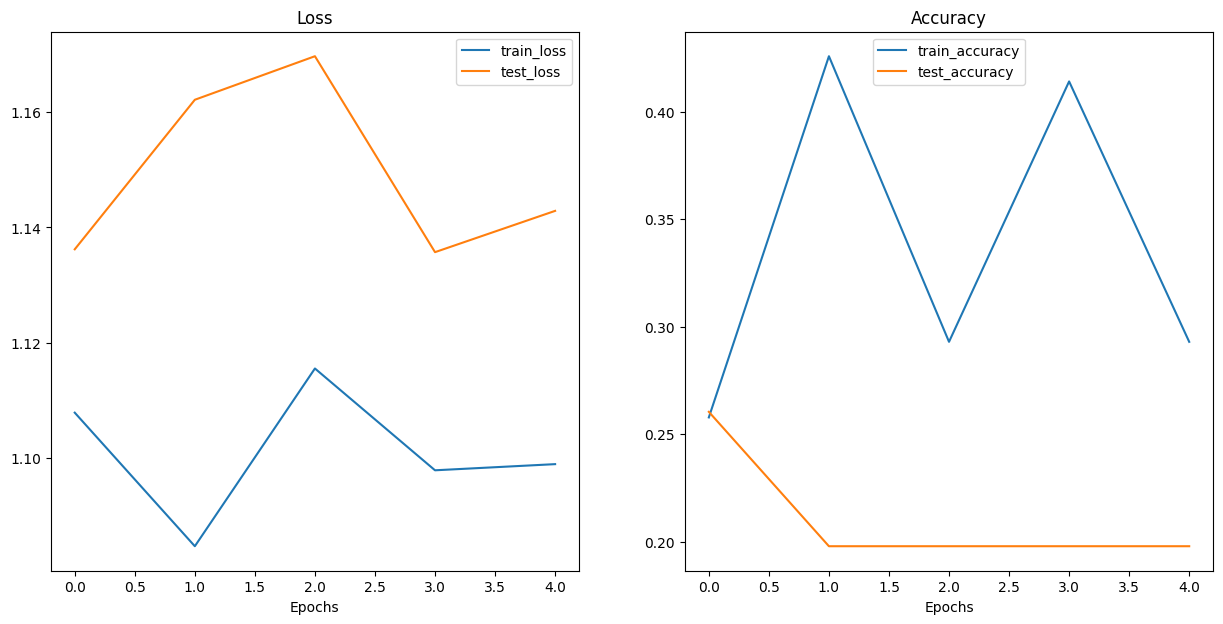

In [48]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?


### 8.1 How to deal with overfitting?

A common technique of preventing overfitting is *regularization*.


### 8.2 How to deal with underfitting?

Our model right now, is underfitting.

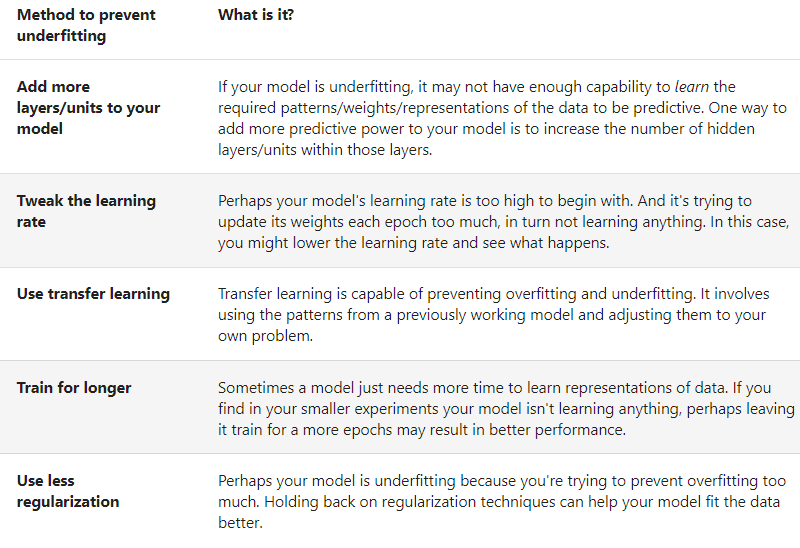

### 8.3 The balance between underfitting and overfitting

Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours and apply it to your dataset.

## 9. Model 1: TinyVGG with Data Augmentation

This time, let's load in the data and use data augmentation to see if it improves our results in anyway

### 9.1 Create transform with data augmentation

In [49]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform with no augmentation
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Datasets and DataLoaders

In [50]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [51]:
# Turn Datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=False)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x29b81235780>,
 <torch.utils.data.dataloader.DataLoader at 0x29b8126b2b0>)

### 9.3 Construct and train Model 1

Now to build our next model, model_1, we can reuse our TinyVGG class from before.

In [53]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

We can reuse the `train()` function

In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1384 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1619 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1476 | test_acc: 0.2604
Total training time: 93.86 seconds


Our model performed badly once again.

### 9.4 Plot the loss curves of Model 1

In [55]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [56]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

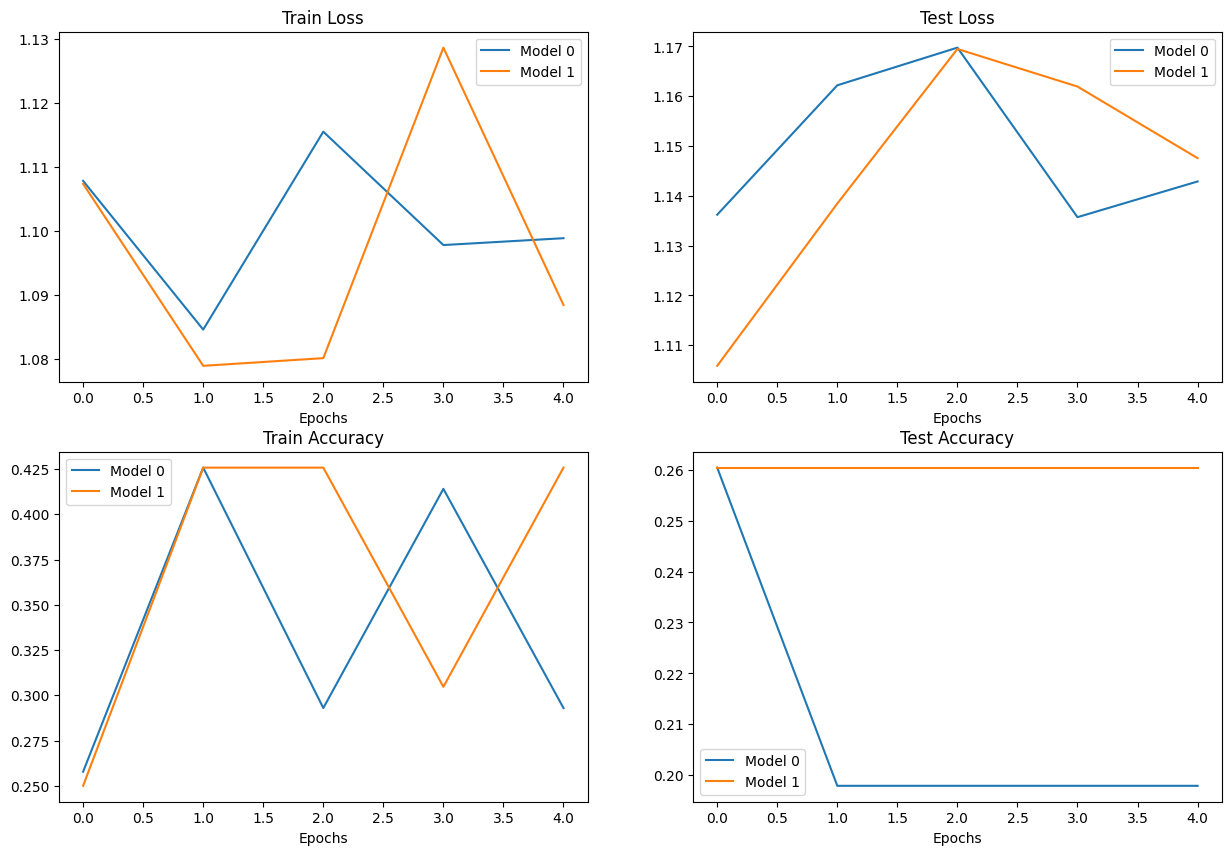

In [57]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

To make a prediction on a custom image, we need to preprocess it in a way that matches the type of data the model was trained on.

In [58]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

In [59]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype

The custom image's datatype is uint8 while our model takes image tensors of datatype float32, so we will need to convert the custom image into float32.

In [60]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [61]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on Custom Image with a trained PyTorch model

We also need to convert our image's shape to [3, 64, 64]. But let's first view the image.

(-0.5, 3023.5, 4031.5, -0.5)

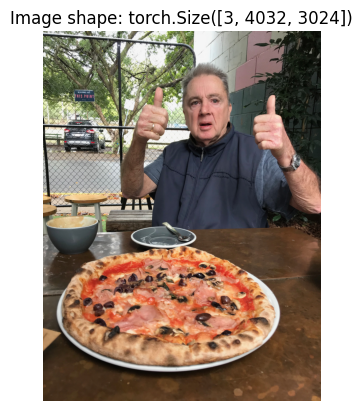

In [62]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0))           # C H W -> H W C
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [63]:
# Create transforms pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [65]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed).to(device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

We forgot about the batch size. Our model expects image tensors with a batch size dimension at the start (`NHCW` where `N` is the batch size).

But our custom image is only CHW right now, so we will add a batch dimension by using `torch.unsqueeze(dim=0)` to add an extra dimension. (Giving it a batch size of 1).

In [66]:
model_1.eval()
with torch.inference_mode():
    # Adding an extra dimension
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Custom image transformed with batch size shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on the image
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0)).to(device)

Custom image transformed shape: torch.Size([3, 64, 64])
Custom image transformed with batch size shape: torch.Size([1, 3, 64, 64])


In [68]:
custom_image_pred

tensor([[ 0.1185,  0.0272, -0.1452]])

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [69]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1185,  0.0272, -0.1452]])
Prediction probabilities: tensor([[0.3730, 0.3405, 0.2865]])
Prediction label: tensor([0])


In [70]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]    # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

Our model gets the prediction right (luckily).

In [71]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3730, 0.3405, 0.2865]])

Having prediction probabilities this similar could mean a couple of things:

1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

### 11.3 Putting custom image prediction together: building a function

1. Takes in a target image path and converts to the right datatype for our model (torch.float32).
2. Makes sure the target image pixel values are in the range [0, 1].
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model.
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

In [72]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:
1. **Wrong datatypes** - Your model expected torch.float32 when your data is torch.uint8.
2. **Wrong data shapes** - Your model expected [batch_size, color_channels, height, width] when your data is [color_channels, height, width].
3. **Wrong devices** - Your model is on the GPU but your data is on the CPU.